In [ ]:
%%writefile load_imgs.py
import cv2
import numpy as np
def load_img(direct,file,size=100):
    pic = cv2.imread(direct+file)
    pic = cv2.resize(pic,(size,size))
    
    if "cat" in file:
        label = 0
    else:
        label = 1
    
    return [pic,label]


In [1]:
import time
start_time = time.time()
import numpy as np
import pandas as pd
from multiprocessing import Pool
from load_imgs import load_img

from tqdm.notebook import tqdm


import cv2
import PIL
from os import listdir
import random

%matplotlib inline
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import accuracy_score, classification_report




randomSeed = 36
np.random.seed(randomSeed)

## <u><b> Part 1 </b></u>

### Loading the data

We will use the multiprocessing library to make loading our images much faster in parallel

In [2]:
picSize = 100
img_to_load = [(r"data/dogs-vs-cats/train/",i,picSize) for i in listdir(r"data/dogs-vs-cats/train/")]

#Will use all cpu cores available
p = Pool(processes=None)

out = p.starmap(load_img,img_to_load)


In [3]:
data = np.array([out[i][0] for i in range(len(out))])
target = [out[i][1] for i in range(len(out))]
out=None

## <u><b> Part 2 </b></u>

### Train/Test split

In [4]:
X_train, X_test, y_train, y_test  = train_test_split(data.reshape(len(data),picSize*picSize*3), target, test_size=0.25, random_state=randomSeed)


## <u><b> Part 3 </b></u>

### Building our Pipeline cutom meathods

We will add all our transformations into a single pipeline so we can apply all our transformations easly


In [5]:
class erode_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, iterations=0,picSize=100):
        self.matrix = matrix
        self.picSize = picSize
        self.iterations=iterations
    def fit(self, Data, y=None):
        return self
    def transform(self,Data,y=None):
        newData = []
        if self.iterations > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize) and Data[i].shape != (self.picSize,self.picSize,3):
                    newData.append(cv2.erode(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,iterations=self.iterations))
                else:
                    newData.append(cv2.erode(Data[i],self.matrix,iterations=self.iterations))
            return newData
        return Data
    def inverse_transform(self,Data,y=None):
        return Data

In [6]:
class dilate_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, iterations=0, picSize=100):
        self.matrix = matrix
        self.iterations=iterations
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self
    def transform(self,Data, y=None):
        newData = []
        if self.iterations > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize) and Data[i].shape != (self.picSize,self.picSize,3):
                    newData.append(cv2.dilate(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,iterations=self.iterations))
                else:
                    newData.append(cv2.dilate(Data[i],self.matrix,iterations=self.iterations))
            return newData
        return Data
    def inverse_transform(self,Data,y=None):
        return Data

In [7]:
class grayScale(BaseEstimator, TransformerMixin):
    def __init__(self,picSize=100):
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self
    def transform(self,Data, y=None):
        newData = []
        for i in range(len(Data)):
            if Data[i].shape != (self.picSize,self.picSize,3):
                newData.append(cv2.cvtColor(Data[i].reshape(self.picSize,self.picSize,3), cv2.COLOR_BGR2GRAY))
            else:
                newData.append(cv2.cvtColor(Data[i], cv2.COLOR_BGR2GRAY))
        return newData
    def inverse_transform(self,Data,y=None):
        return Data

In [8]:
class reShape(BaseEstimator, TransformerMixin):
    def __init__(self,picSize=100):
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self

    def transform(self,Data, y=None):
        processed_data = np.array(Data)
        processed_data = np.array([a.flatten() for a in processed_data])
        return processed_data

    def inverse_transform(self, Data,y=None):
        newData = Data.copy()
        newData = newData.reshape(len(newData),self.picSize,self.picSize)
        return newData

In [9]:
class to_df(BaseEstimator, TransformerMixin):
    
    def fit(self, Data, y=None):
        return self

    def transform(self,Data, y=None):
        df = pd.DataFrame(Data)
        return df
    def inverse_transform(self, Data,y=None):
       
        newData = Data.to_numpy()
        return newData

## <u><b> Part 4 </b></u>

### Visualizing our pipeline transformations

We will go over what our pipeline does behind the scenes

The steps are as follows:

1. Transforming the images by bluring, dilating, eroding and gray scaling the images
2. Transforming the 2d image matrices to a 1d arrays in a data frame
3. Reducing the images dimension with pca and finding the best dimension
4. Moving our data into a Dataframe

 Step 1: Transforming the data

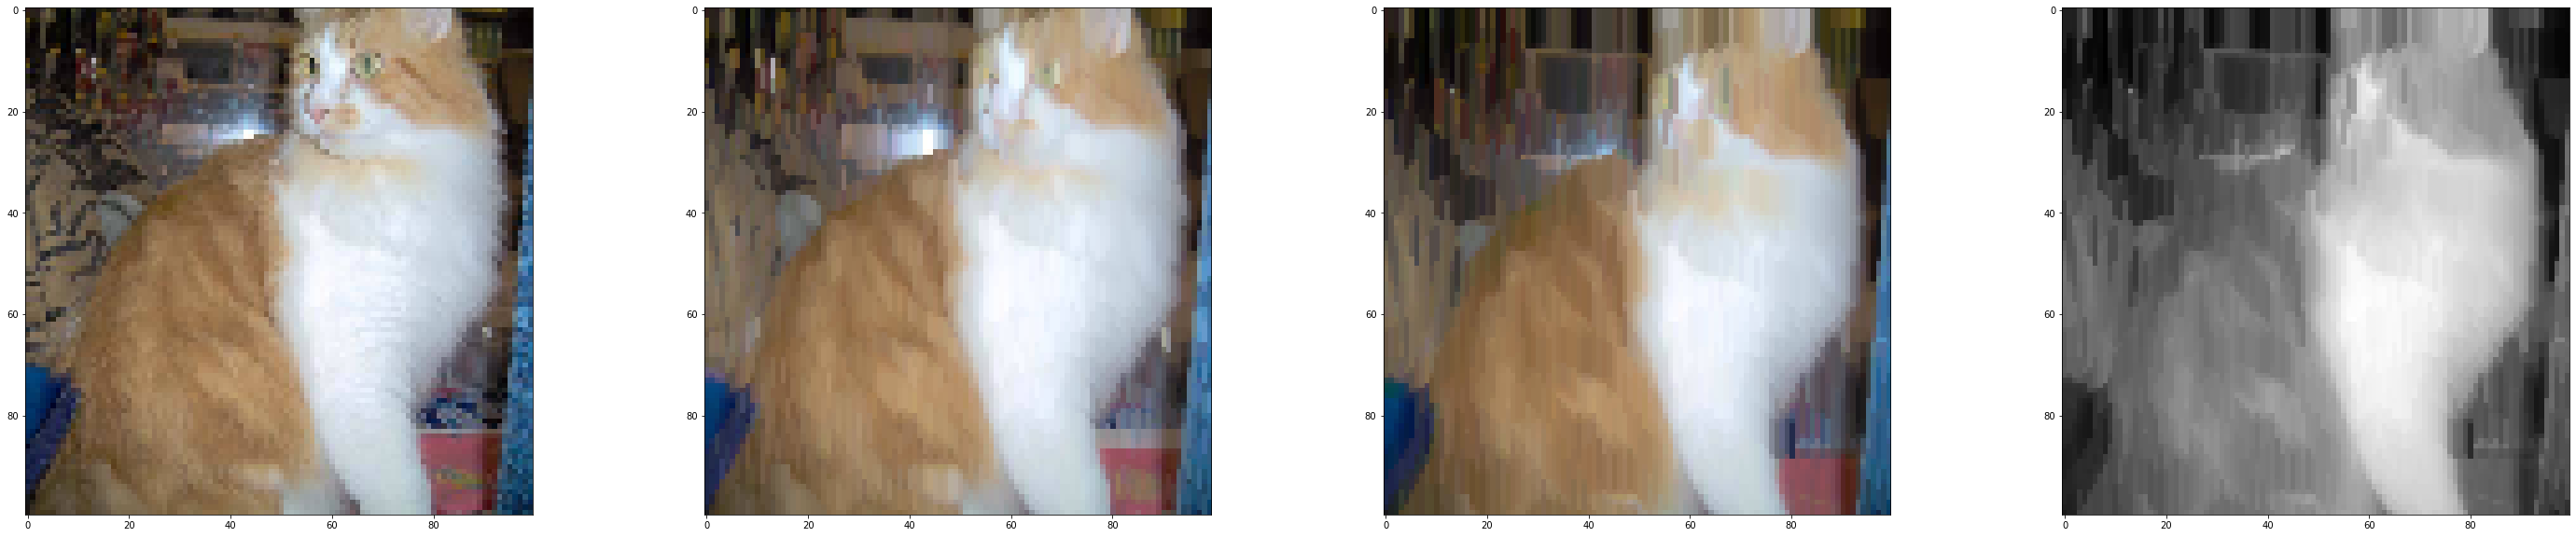

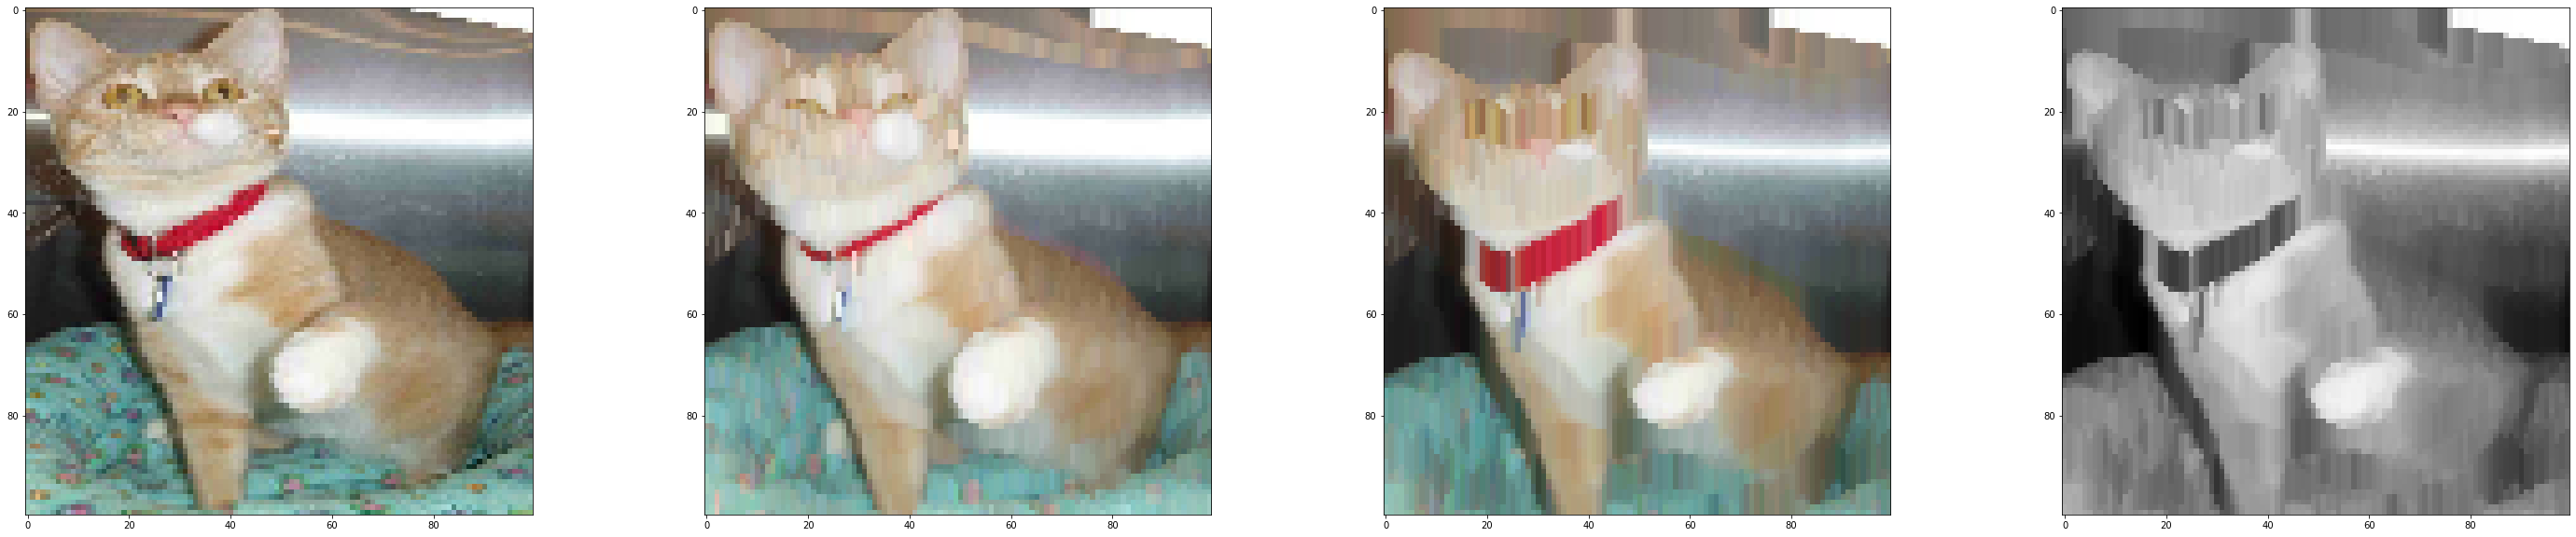

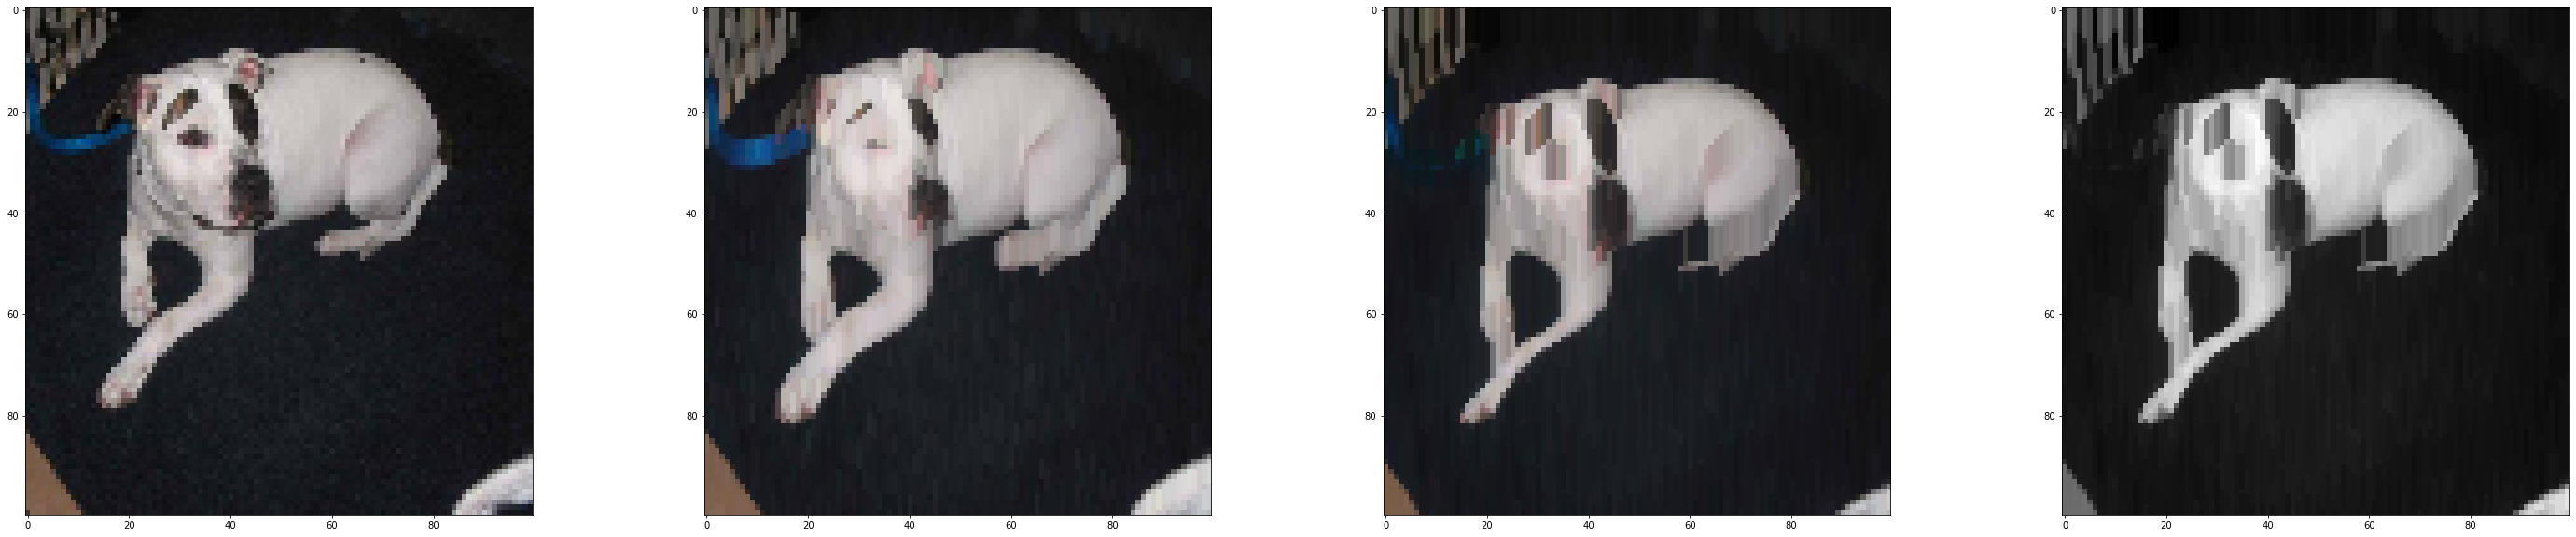

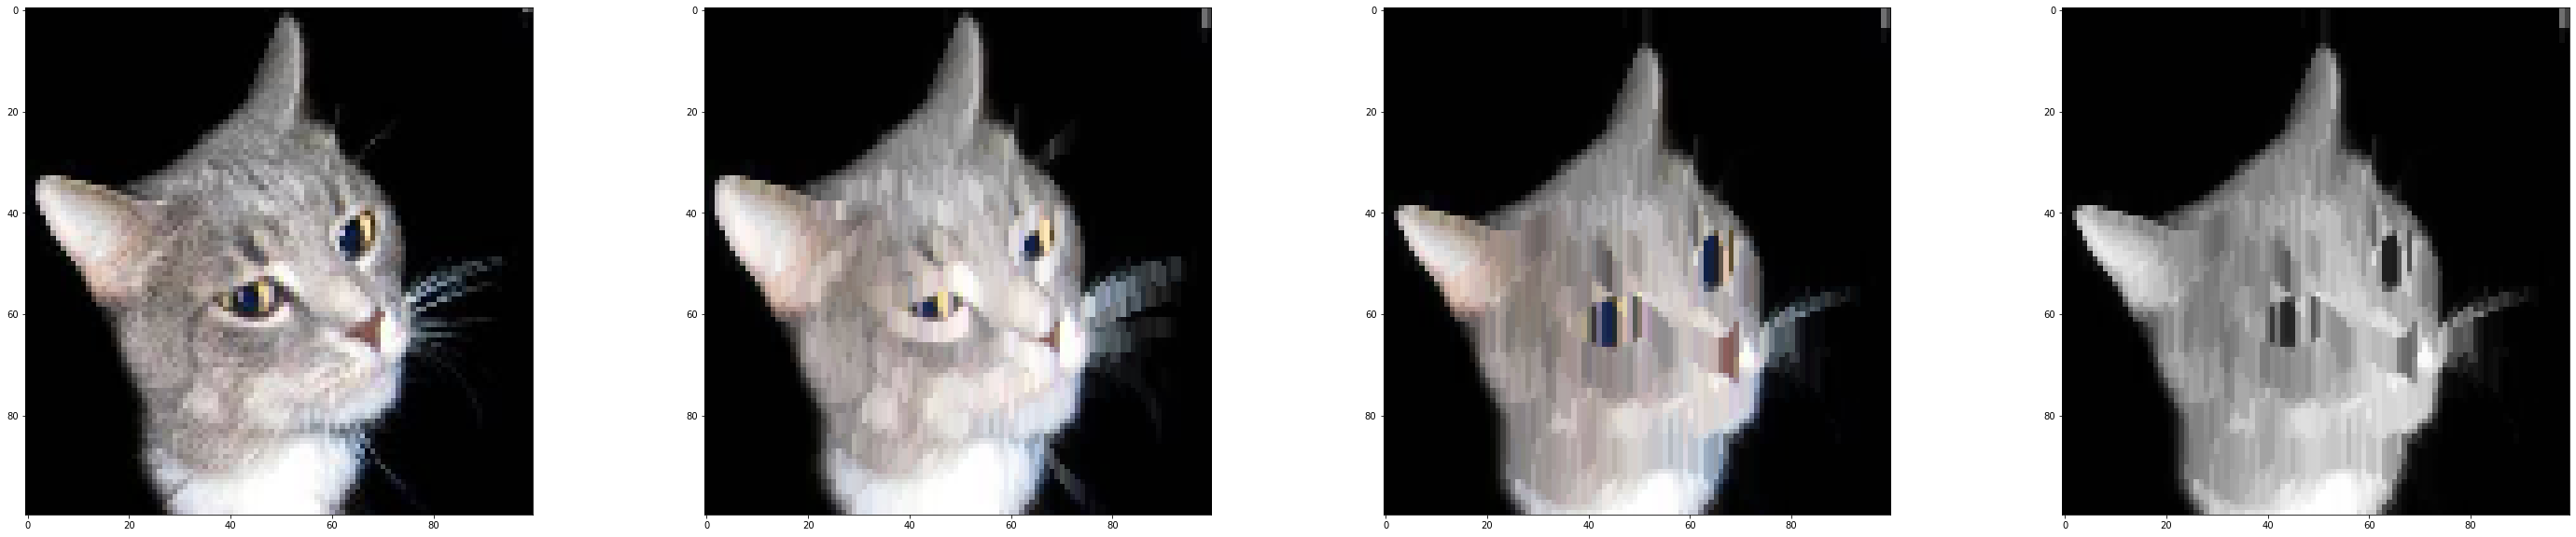

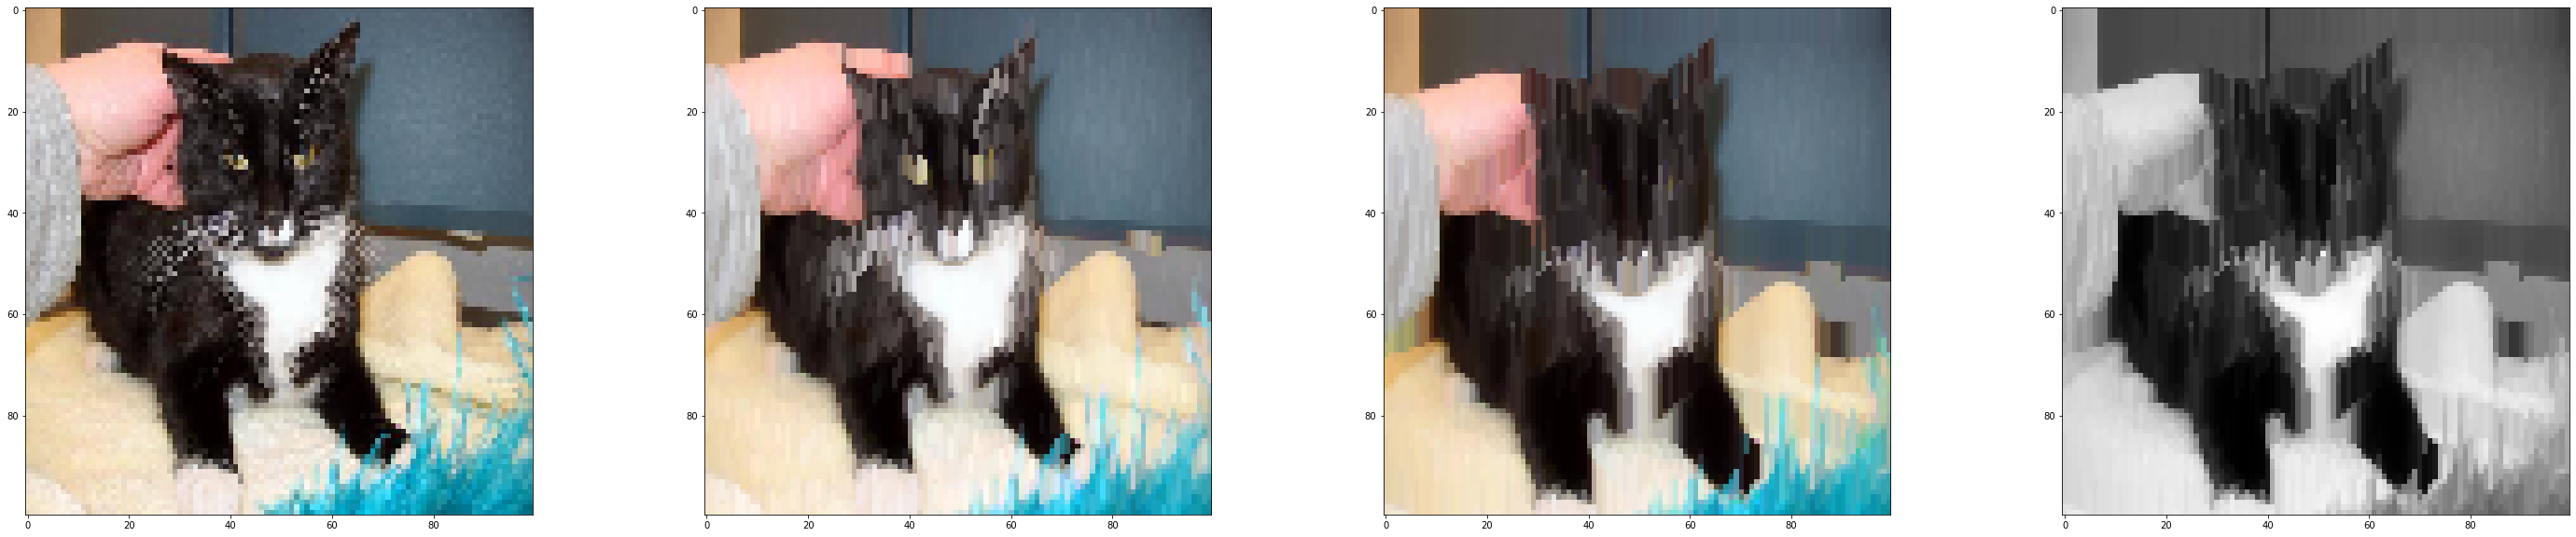

In [10]:
for i in range(5):
   
    dilated = cv2.dilate(data[i],(1,1),iterations=3)
    eroded = cv2.erode(dilated,(3,3),iterations=6)
    grayScaled = cv2.cvtColor(eroded, cv2.COLOR_BGR2GRAY)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(50,10)
    ax1.imshow(cv2.cvtColor(data[i],cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(dilated,cv2.COLOR_BGR2RGB))
    ax3.imshow(cv2.cvtColor(eroded,cv2.COLOR_BGR2RGB))
    ax4.imshow(grayScaled,cmap="gray")

Here we have our Image transformation pipeline

In [12]:
img_preprocessing = Pipeline([
    ("dilate",dilate_img(picSize=picSize)),
    ("erode",erode_img(picSize=picSize)),
    ("grayScale",grayScale(picSize=picSize)),
    ("reshape",reShape(picSize=picSize)),
    ("scaler",StandardScaler()),
    ("toDF", to_df())
])

Step 2: Reducing dimensions

We will first try to reduce our dimensions of our original train set without any transformations

In [13]:
X_train_new = img_preprocessing.fit_transform(X_train)
X_test_new = img_preprocessing.transform(X_test)
X_train_new.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.983293,1.976879,1.774437,1.915349,1.651994,-0.741122,-0.189171,-0.750340,-1.102084,-0.728365,...,-1.165990,-1.570891,-1.305179,-1.343749,-1.423488,-1.440819,1.995110,1.952081,2.017177,2.019640
1,0.767859,0.772560,0.784982,0.795146,0.789001,0.783586,0.760652,0.759621,0.779350,0.778864,...,1.066853,1.130663,1.180639,1.203250,1.270312,1.397696,1.451462,1.440027,1.219687,0.879618
2,2.011891,2.005553,2.003875,2.001518,1.997191,1.991846,1.983909,1.981970,1.971403,1.970293,...,1.719998,1.798462,1.832408,1.855161,1.815126,1.835552,1.874299,1.876779,1.866708,1.884637
3,-1.191134,-1.148615,-1.581105,-1.488344,-1.239034,-1.158259,-1.095820,-1.167377,-0.671221,-0.642238,...,-0.831823,-0.599546,-0.592780,-0.691839,-1.347819,-1.320031,-1.327188,-1.331085,-1.338299,-1.235422
4,1.625812,1.718811,1.573678,1.814818,1.867742,1.919925,1.897561,1.651217,0.032521,-0.068055,...,1.279505,1.267258,1.271584,1.279054,1.270312,1.246711,1.255144,1.289423,1.264828,1.254625


In [14]:
#X_train_new = np.array([cv2.cvtColor(i.reshape(picSize,picSize,3), cv2.COLOR_BGR2GRAY) for i in X_train])
#X_test_new = np.array([cv2.cvtColor(i.reshape(picSize,picSize,3), cv2.COLOR_BGR2GRAY) for i in X_test])
#X_train_new = X_train_new.reshape((len(X_train_new),picSize*picSize))
#X_test_new = X_test_new.reshape((len(X_test_new),picSize*picSize))
#X_train_new.shape

In [15]:
pca = PCA(random_state=randomSeed)
pca.fit(X_train_new)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)


Feature variance ratio without any transformations

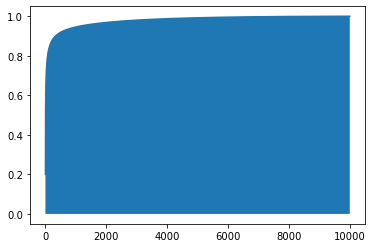

In [16]:
fig, ax = plt.subplots()
ax.plot(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul)
ax.fill_between(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul,0)

In [17]:
maxFeatures = len(exp_var_cumul[exp_var_cumul<0.95])
exp_var_cumul[maxFeatures], maxFeatures

(0.950016640342817, 1130)

step 3: Finding optimal paramaters for transformations

In [18]:
 
grid = {
    'dilate__matrix':[(3,3),(5,5)],
    'dilate__iterations':[3,6,9],
    'erode__matrix':[(5,5)],
    'erode__iterations':[3,6,9]
}
params = ParameterGrid(grid)

In [37]:
def get_best_transformations(params,threshold=0.95,verbose=True,plot=True,df_out=None):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    if plot==False:
        print("Testing",len(params),"combinations of paramaters")
        start = time.time()
        last_update = time.time()
        param_combo = {
            'dilate__matrix':[],
            'dilate__iterations':[],
            'erode__matrix':[],
            'erode__iterations':[]
        }
        best_params = {
            'dilate__matrix':None,
            'dilate__iterations':None,
            'erode__matrix':None,
            'erode__iterations':None
        }
        trainAcc = []
        testAcc = []
        dims = []
        times = []

        

        best_dim =  picSize**2
        with tqdm(total=len(params)) as pbar:
            for param in params:

                img_preprocessing.set_params(**param)
                X_train_new = img_preprocessing.fit_transform(X_train)
                X_test_new = img_preprocessing.transform(X_test)

                pca = PCA(n_components=threshold,random_state=randomSeed)
                X_train_new = pca.fit_transform(X_train_new)
                X_test_new = pca.transform(X_test_new)

                exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
                maxFeatures = len(exp_var_cumul[exp_var_cumul<threshold])

                train = xgb.DMatrix(X_train_new,label=y_train)
                test = xgb.DMatrix(X_test_new,label=y_test)
                evals = [(train,'train')]
                fit_time = time.time()
                params = {'tree_method':'hist','eval_metric': 'auc','num_class':2,"random_state":randomSeed}
                model = xgb.train(params,train, num_boost_round=1000,evals=evals, early_stopping_rounds=30,verbose_eval=False)
                test_preds = model.predict(test)
                train_preds = model.predict(train)
                te_acc = accuracy_score(y_test,test_preds)
                tr_acc = accuracy_score(y_train,train_preds)
                testAcc.append(te_acc)
                trainAcc.append(tr_acc)
                dims.append(maxFeatures)
                times.append(time.time()-fit_time)
                print("Dimesion:",maxFeatures,"Train Accuracy:",tr_acc,"Test Accuracy:",te_acc,"fit_time: "+str(time.time()-fit_time)+"s")

                for key in param:
                    param_combo[key].append(param[key])

                if maxFeatures < best_dim:
                    best_dim = maxFeatures
                    best_params = param
                best_params["pca__n_components"] = best_dim
                if time.time() - last_update > 60:
                    print(str((time.time()-start)/60)+"m elapsed")
                    last_update = time.time()
                pbar.update(1)

        df_out = dict({"Dimensions":dims,"Train accuracy":trainAcc,"Test accuracy":testAcc,"Train time":times},**param_combo)
        df_out = pd.DataFrame(df_out)
        
    df_out = df_out.sort_values(by="Dimensions")
    ax1.plot(df_out["Dimensions"],df_out["Test accuracy"],'o-')
    ax2.plot(df_out["Dimensions"],df_out["Train accuracy"],'o-')
    ax3.plot(df_out["Dimensions"],df_out["Train time"],'o-')
    ax1.set_title("test")
    ax2.set_title("train")
    ax3.set_title("fit time vs dimensions")
    if plot:
        return df_out 
    return best_params, df_out


Testing 18 combinations of paramaters


  0%|          | 0/18 [00:00<?, ?it/s]

Dimesion: 539 Train Accuracy: 0.9999466666666667 Test Accuracy: 0.62352 fit_time: 42.04862332344055s
5.245364816983541m elapsed
Dimesion: 380 Train Accuracy: 1.0 Test Accuracy: 0.62896 fit_time: 29.33032774925232s
10.257109129428864m elapsed
Dimesion: 322 Train Accuracy: 1.0 Test Accuracy: 0.6264 fit_time: 25.212170600891113s
15.200547269980113m elapsed
Dimesion: 539 Train Accuracy: 0.9999466666666667 Test Accuracy: 0.62352 fit_time: 42.069241523742676s
20.44342180887858m elapsed
Dimesion: 380 Train Accuracy: 1.0 Test Accuracy: 0.62896 fit_time: 29.297385215759277s
25.469008886814116m elapsed
Dimesion: 322 Train Accuracy: 1.0 Test Accuracy: 0.6264 fit_time: 25.156548023223877s
30.423167022069297m elapsed
Dimesion: 432 Train Accuracy: 0.9999466666666667 Test Accuracy: 0.62416 fit_time: 32.854357957839966s
35.51649609406789m elapsed
Dimesion: 383 Train Accuracy: 1.0 Test Accuracy: 0.63904 fit_time: 28.74957799911499s
40.53474536339442m elapsed
Dimesion: 302 Train Accuracy: 0.999946666666

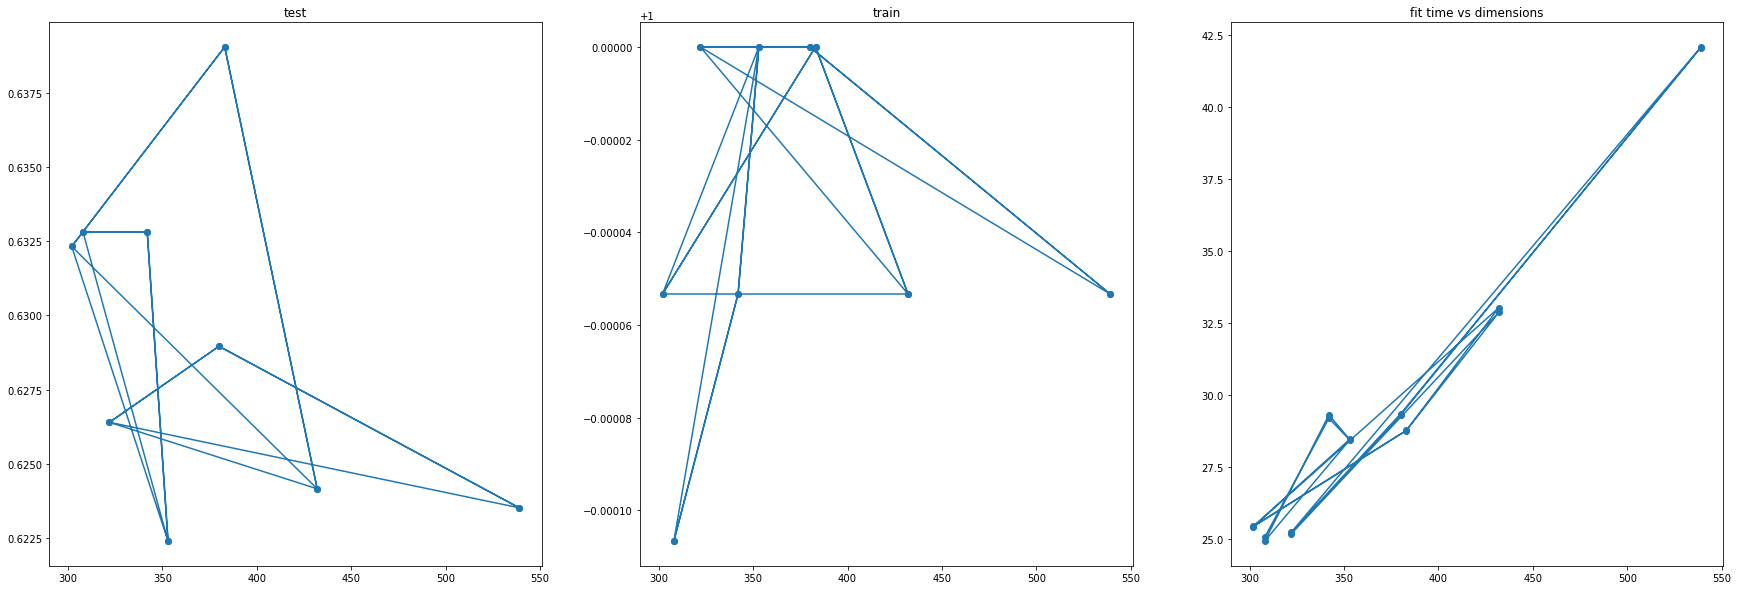

In [22]:
params, param_results= get_best_transformations(params,threshold=0.95)


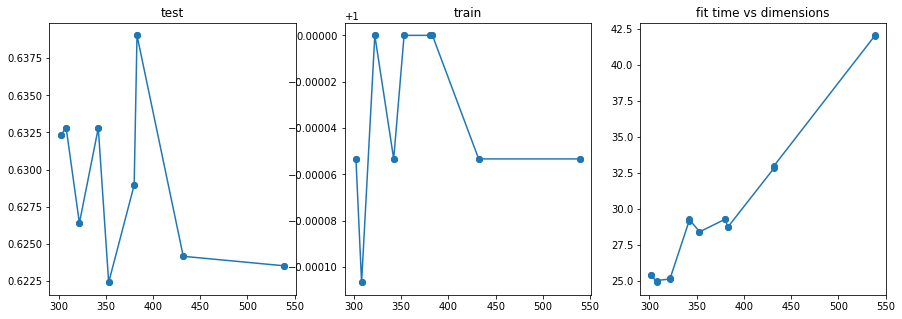

In [38]:
param_results= get_best_transformations(params,threshold=0.95,df_out=param_results,plot=True)


In [39]:
param_results

,Dimensions,Train accuracy,Test accuracy,Train time,dilate__matrix,dilate__iterations,erode__matrix,erode__iterations
8,302,0.999947,0.63232,25.413692,"(3, 3)",6,"(5, 5)",9
11,302,0.999947,0.63232,25.427146,"(5, 5)",6,"(5, 5)",9
14,308,0.999893,0.63280,24.911522,"(3, 3)",9,"(5, 5)",9
17,308,0.999893,0.63280,25.044948,"(5, 5)",9,"(5, 5)",9
5,322,1.000000,0.62640,25.156546,"(5, 5)",3,"(5, 5)",9
2,322,1.000000,0.62640,25.212169,"(3, 3)",3,"(5, 5)",9
16,342,0.999947,0.63280,29.177831,"(5, 5)",9,"(5, 5)",6
13,342,0.999947,0.63280,29.291200,"(3, 3)",9,"(5, 5)",6
12,353,1.000000,0.62240,28.443831,"(3, 3)",9,"(5, 5)",3
15,353,1.000000,0.62240,28.423186,"(5, 5)",9,"(5, 5)",3


We can see that with 308 and 302 dimensions we have pretty good results so we will use 308 dimensions since its 
slightly more accurate although it has 6 dimensions more

In [ ]:
best_params = {
    'dilate__matrix':(5, 5),
    'dilate__iterations':9,
    'erode__matrix':(5,5),
    'erode__iterations':9
}

step 4: Adding our paramaters to a new pipeline

In [ ]:
pipe = Pipeline([
    ("dilate",dilate_img(picSize=picSize)),
    ("erode",erode_img(picSize=picSize)),
    ("grayScale",grayScale(picSize=picSize)),
    ("reshape",reShape(picSize=picSize)),
    ("scaler",StandardScaler()),
    ("pca",PCA(random_state=randomSeed)),
    ("toDF", to_df())
],verbose=True)

pipe.set_params(**params)


In [ ]:
X_train_new = pipe.fit_transform(X_train)
X_test_new = pipe.transform(X_test)

In [ ]:
X_train_new.head(5)

Image before and after transformations

In [ ]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10,5)
    img = X_train[i].reshape(picSize,picSize,3)
    ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    pca = PCA(random_state=randomSeed,)
    img = pipe.inverse_transform(X_train_new)[i]
    
    ax2.imshow(img.reshape((picSize,picSize)),cmap="gray")
    img = None

## <u><b> Part 5 </b></u>

### Baseline model

This will act as a baseline model and we will try to improve it

In [ ]:
def plot_model_results(model,X,y):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    cm = plot_confusion_matrix(model,X,y,display_labels=["cat","dog"],values_format="d",ax=ax1)
    fig.set_size_inches(20,10)
    num = cm.text_[0][0].get_text()
    txt = "True Negative"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[0][0].set_text(txt)
    
    num = cm.text_[1][0].get_text()
    txt = "False Negative"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[1][0].set_text(txt)

    num = cm.text_[0][1].get_text()
    txt = "False Positive"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[0][1].set_text(txt)

    num = cm.text_[1][1].get_text()
    txt = "True Positive"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[1][1].set_text(txt)
    
    falsePosRate, truePosRate, _ = roc_curve(y,np.random.choice([0,1],size=len(y_test)))
    plot_roc_curve(model,X,y,ax=ax2)
    ax2.plot(falsePosRate, truePosRate, linestyle='--')

In [ ]:
baseline = xgb.XGBClassifier(n_estimators = 200, seed=randomSeed,tree_method='hist',eval_metric="logloss")
baseline.fit(X_train_new,y_train)
baseline_prediction = baseline.predict(X_test_new)

In [ ]:
print("Accuracy:",accuracy_score(y_test,baseline_prediction))
print(classification_report(y_test,baseline_prediction))


In [ ]:
plot_model_results(baseline,X_test_new,y_test)

In [ ]:
#train_scoreNum, test_scoreNum = validation_curve(AdaBoostClassifier(random_state=randomSeed), X = X_train_new, y = y_train, param_name = 'n_estimators', param_range = [200,600,800,1200], cv = 5, n_jobs=-1, verbose = 1)

In [ ]:
#train_score_mean = np.mean(train_scoreNum,axis=1)
#train_score_std = np.std(train_scoreNum,axis=1)
#test_score_mean = np.mean(test_scoreNum,axis=1)
#test_score_std= np.std(test_scoreNum,axis=1)
#plt.semilogx([200,600,800,1200],train_score_mean)
#plt.fill_between([200,600,800,1200],train_score_mean-train_score_std,train_score_mean+train_score_std, alpha=0.2)
#plt.semilogx([200,600,800,1200],test_score_mean)
#plt.fill_between([200,600,800,1200],test_score_mean-test_score_std,test_score_mean+test_score_std, alpha=0.2)
#plt.show()

## <u><b> Part 6 </b></u>

### Paramater tuning



In [ ]:
def param_search(param_grid,train,test,train_labels,test_labels,num_class=2,randomSeed=randomSeed,nfolds=5,eval_method="auc",higher_better=True,num_boost_round=10000,early_stopping_rounds=100,verbose=True):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    done = 0
    amount = len(param_grid)
    params = {
        'random_state':randomSeed,
        'eval_metric':eval_method,
    }
    start = time.time()
    timer = time.time()
    if higher_better: 
        best_eval = -float("inf")
    else:
        best_eval = float("inf")
    best_eval_train = 0
    best_params = {}
    best_iter = 0
    best_out = ''
    with tqdm(total=len(param_grid)) as pbar:
        for p in param_grid:
            out = ''
            for key in p:
                params[key] = p[key]
                out += key + '=' + str(p[key])+', '
            out = out[:-2]
            
            results = xgb.cv(params,train,num_boost_round=num_boost_round,nfold=nfolds,metrics={eval_method},early_stopping_rounds=early_stopping_rounds,seed=randomSeed)
            
            ax1.plot(results.index,results['test-'+eval_method+'-mean'],label=out[:25])
            ax2.plot(results.index,results['train-'+eval_method+'-mean'],label=out[:25])
            ax1.set_title("validation")
            ax2.set_title("train")
            ax1.legend()
            ax2.legend()
            
            done +=1 
            #get mean score of cv of the training and testing, and get the best iteration
            if higher_better==False:
                mean_eval_test = results['test-'+eval_method+'-mean'].min()
                mean_eval_train = results['test-'+eval_method+'-mean'].min()
                iteration = results['test-'+eval_method+'-mean'].argmin()
            else: 
                mean_eval_test = results['test-'+eval_method+'-mean'].max()
                mean_eval_train = results['test-'+eval_method+'-mean'].max()
                iteration = results['test-'+eval_method+'-mean'].argmax()
            
            #update best parameters
            if (mean_eval_test < best_eval and higher_better==False) or (mean_eval_test > best_eval and higher_better):
                best_eval = mean_eval_test
                best_eval_train = mean_eval_train
                best_out = ''
                best_iter = iteration
                for key in p:
                    best_out += key + '=' + str(p[key])+', '
                    best_params[key] = p[key]
                best_out = best_out[:-2]

            #show results of cv
            if verbose:
                print("Parameters: "+out)
                print("Mean train "+eval_method+": "+str(mean_eval_train) + " Mean test "+eval_method+": "+str(mean_eval_test) + " Iteration: "+str(iteration))
                print(str(done)+"/"+str(amount))
                
                if (time.time()-timer) > 300:
                    print(str((time.time()-start)/60) +"m elapsed. Finished "+str(100*done/amount)+"%" )
                    timer = time.time()
                print("")
            pbar.update(1)
    stop = time.time()
    if verbose:
        print("----------------------------------------")
    print(f"Tuning time: {(time.time()-start)}s")
    print("Best parameters: "+best_out+":")
    print("Best mean train "+eval_method+": "+str(best_eval_train) + " Best mean test "+eval_method+": "+str(best_eval) + " Best iteration: "+str(best_iter))
    
    #show accuracy score
    bst = xgb.train(dict({'random_state':randomSeed,'eval_metric':eval_method,'num_class':num_class},**best_params), train, best_iter+1)
    test_preds = bst.predict(test)
    train_preds = bst.predict(train)

    print("Test accuracy:",accuracy_score(test_labels,test_preds),"Train accuracy:",accuracy_score(train_labels,train_preds))
    return best_params,best_iter+1

In [ ]:
dtrain = xgb.DMatrix(X_train_new, label=y_train)
dtest = xgb.DMatrix(X_test_new, label=y_test)

In [ ]:
params = {
    'tree_method':'hist',
    'n_jobs':-1
}

In [ ]:
grid = [
    dict({'learning_rate':lr},**params) 
    for lr in [0.025,0.05,0.1,0.3]
]

In [ ]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [ ]:
grid = [
    dict({'max_depth':i,'min_child_weight':j},**params)
    for i in [5,6,7]
    for j in [3,5,7]
]

In [ ]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [ ]:
grid = [
    dict({'gamma':g},**params) 
    for g in [0,5]
]

In [ ]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [ ]:
grid = [
    dict({'subsample':i,'colsample_bytree':j},**params) 
    for i in [0.5,0.6,0.7,1]
    for j in [0.9,0.95,1]
]

In [ ]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [ ]:
grid = [
    dict({'reg_lambda':i},**params) 
    for i in [1,18,20,22]
]

In [ ]:
params,estimators = param_search(grid,dtrain,dtest,y_train,y_test)

## <u><b> Part 7 </b></u>

### Making our final model

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators = estimators, random_state=randomSeed,**params,eval_metric="logloss")

In [ ]:
xgb_model.fit(X_train_new,y_train)

In [ ]:
pred_xgb = xgb_model.predict(X_test_new)

In [ ]:
print("Accuracy:",accuracy_score(y_test,pred_xgb))
print(classification_report(y_test,pred_xgb))

In [ ]:
plot_model_results(xgb_model,X_test_new,y_test)

## <u><b> Part 8: </b></u>
### Testing model on the final data

We will now fit our model using the entire training data, and check our accuracy on the final test data

In [ ]:
img_to_load = [(r"data/dogs-vs-cats/test1/",i,picSize) for i in listdir(r"data/dogs-vs-cats/test1/")]

p = Pool(processes=4)

out = p.starmap(load_img,img_to_load)

In [ ]:
test_data = np.array([out[i][0] for i in range(len(out))])
out=None
test_data.shape

In [ ]:
model = xgb.XGBClassifier(n_estimators = estimators, random_state=randomSeed,**params,eval_metric="logloss")

In [ ]:
X_train = pipe.fit_transform(data)
test_data = pipe.transform(test_data)

In [ ]:
model.fit(X_train,target)

In [ ]:
pred = model.predict(test_data)
submission = {"id":[i+1 for i in range(len(test_data))],"label":pred}
submission = pd.DataFrame(data=submission)
submission.head(10)

In [ ]:
submission.to_csv(r"data/dogs-vs-cats/sampleSubmission.csv",sep='\t')

In [ ]:
end_time = time.time()
e = end_time-start_time


In [ ]:
print('{:0.0f}:{:0.0f}:{:0.0f}'.format(e // 3600, (e % 3600 // 60), e % 60))